# Gridding ecoregions and land cover estimates for CMIP5 model output common grid.  

The relationship between wildfire activity and meteorology vary by land cover type. Further, land cover is expected to change in the future due to both climate change and/or use change. Thus, we need to know what proportion of CMIP5 grid boxes area are made up of forests, shrubs, and grass, the three major splits in land cover in terms of emission factors. 


TODO: I need a product that shows me the percent of land cover area within a CMIP5 model grid box. E.g., 40% grass, 20% forest, 40% shrubs. 

For now:

Data source: https://landcover.usgs.gov/global_climatology.php

## 0.5 km MODIS-based Global Land Cover Climatology

Description: These data describe land cover type, and are based on 10 years (2001-2010) of Collection 5.1 MCD12Q1 land cover type data. The map is generated by choosing, for each pixel, the land cover classification with the highest overall confidence from 2001-2010, as described in Broxton et al., 2014. As such, they are reflective of the training data for the MDC12Q1 data. Near the edges of the map (generally within 0.05 degrees of 180 degrees longitude, and over parts of Antarctica-mostly south of -85 degrees latitude), we have also manually filled obvious spurious edge effects with nearby land cover types. The data has been re-gridded from the MODIS sinusoidal grid to a regular latitude-longitude grid, and the map has 43200x86400 pixels (corresponding to a resolution of 15 arc seconds).


| Value        | Label          |
| -------------|:-------------|
|0 | Water|
|1|Evergreen Needleleaf forest|
|2|Evergreen Broadleaf forest|
|3|Deciduous Needleleaf forest|
|4|Deciduous Broadleaf forest|
|5|Mixed forest|
|6|Closed shrublands|
|7|Open shrublands|
|8|Woody savannas|
|9|Savannas|
|10|Grasslands|
|11|Permanent wetlands|
|12|Croplands|
|13|Urban and built-up|
|14|Cropland/Natural vegetation mosaic|
|15|Snow and ice|
|16|Barren or sparsely vegetated|



Read in the VERY large (~3 Gb) geotiff file. 

In [1]:
import gdal
import os
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

dataDir = os.path.join("..","..","metSpreadData", "GIS")
f = os.path.join(dataDir, "LCType.tif")
gtif = gdal.Open( f )
print gtif.GetMetadata()
data = np.array(gtif.GetRasterBand(1).ReadAsArray())
print data.shape

{'AREA_OR_POINT': 'Area'}
(43200, 86400)


In [56]:
lc_vals = np.unique(data)
print lc_vals
n_unique_lc = len(lc_vals)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


NameError: name 'nlc_vals' is not defined

In [57]:
n_unique_lc

17

In [34]:
# Get the coordinates 
width = gtif.RasterXSize
height = gtif.RasterYSize
gt = gtif.GetGeoTransform()

print width
print height
print type(gt)

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

print minx
print maxx
print miny
print maxy

# Logically speaking, the data should span the length of the min and max coord values
# by the number of dim size. 
x = np.linspace(minx, maxx, data.shape[1])
y = np.linspace(maxy, miny, data.shape[0])

86400
43200
<type 'tuple'>
-179.999999998
180.000000002
-90.0000000081
89.9999999919


In [25]:
# get washington lon and lat indecies 
yi = np.where((y <= 49.) & (y >= 45.) )[0]
xi = np.where((x >= -125.) & (x <= -116.) )[0]

### Visualize the data and the grid you have created to make sure it makes sense. 

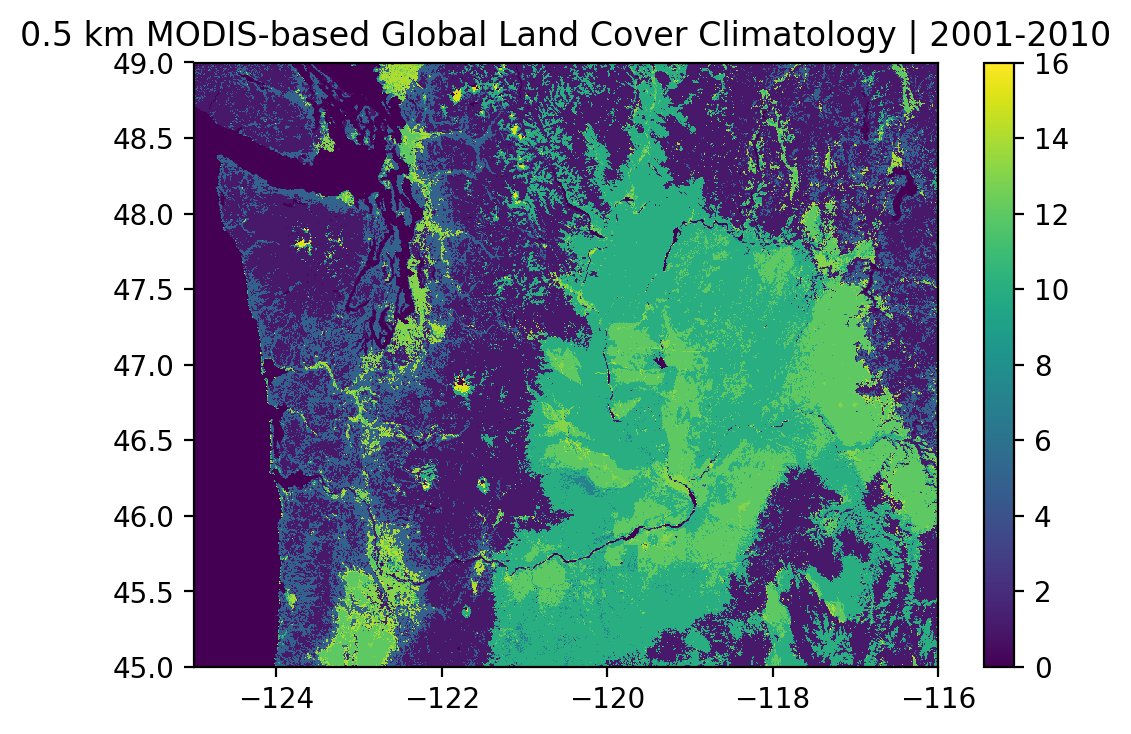

In [26]:
plt.figure(dpi=200)
plt.pcolor(x[xi],y[yi], data[np.ix_(yi, xi)])
plt.colorbar()
plt.title("0.5 km MODIS-based Global Land Cover Climatology | 2001-2010")
plt.show()

### Save this as a netCDF file. (makes a huge file that is not needed, so leaving as raw text for now)


Regrid these data to the CMIP5 (or any passed grid) and preserve all the information of the original by showing percent of each land cover within a given climate grid. 

What does this look like regridded to a very course grid? These will be regridded via CDO remapbil

## These data need to be regridded while preserving the information, but losing spatial detial. 

In [99]:
# TODO: calculate 0.5 x 0.5 km grid area in meters to keep track of actuall areas. 

lon = np.linspace(1.25, 358.75, 144) - 180. # to be changed to 0:360 later. 
lat = np.linspace(-89, 89, 90)

nLat = len(lat)
nLon = len(lon)

X = np.zeros((n_unique_lc , nLat, nLon))

for i in range(len(x)):
    for j in range(len(y)):
        
        # Get the land cover for this grid location. This will also serve as an index
        # For keeping track of land cover counts. 
        lc = data[j,i]
        
        # Figure out what grid center on the new grid it is closest to
        dy = np.abs(lat - y[j])
        yi = np.argmin(dy)
        
        dx = np.abs(lon - x[i])
        xi = np.argmin(dx)
        
        if dx[xi] > (2.5/2+0.00001):
            print dx[xi]
            raise ValueError("Dx is too big at index: "+str(i)+", "+ str(j))
        elif dy[yi] > (1.0+0.00001):
            print dy[yi]
            raise ValueError("Dy is too big at index: "+str(i)+", "+ str(j))
        
        # Add another grid of this land cover. 
        X[lc, yi, xi] = X[lc, yi, xi] + 1.
                
        if (i%1000==0) & (j==0):
            print str(i*1.0/len(x)*100) + " %"

0.0 %
0.115740740741 %
0.231481481481 %
0.347222222222 %
0.462962962963 %
0.578703703704 %
0.694444444444 %
0.810185185185 %
0.925925925926 %
1.04166666667 %
1.15740740741 %
1.27314814815 %
1.38888888889 %
1.50462962963 %
1.62037037037 %
1.73611111111 %
1.85185185185 %
1.96759259259 %
2.08333333333 %
2.19907407407 %
2.31481481481 %
2.43055555556 %
2.5462962963 %
2.66203703704 %
2.77777777778 %
2.89351851852 %
3.00925925926 %
3.125 %
3.24074074074 %
3.35648148148 %
3.47222222222 %
3.58796296296 %
3.7037037037 %
3.81944444444 %
3.93518518519 %
4.05092592593 %
4.16666666667 %
4.28240740741 %
4.39814814815 %
4.51388888889 %
4.62962962963 %
4.74537037037 %
4.86111111111 %
4.97685185185 %
5.09259259259 %
5.20833333333 %
5.32407407407 %
5.43981481481 %
5.55555555556 %
5.6712962963 %
5.78703703704 %
5.90277777778 %
6.01851851852 %
6.13425925926 %
6.25 %
6.36574074074 %
6.48148148148 %
6.59722222222 %
6.71296296296 %
6.8287037037 %
6.94444444444 %
7.06018518519 %
7.17592592593 %
7.29166666667 %

### Save these data as an numpy array, just in case! 

In [116]:
# There should be roughly equal numbers of assignments in each grid box. 
np.save("LC_count.npz", X)
print X.shape

(17, 90, 144)


### Convert counts into percentages and sanity check the locaitons of assignments by plotting individual layers

[288000.]


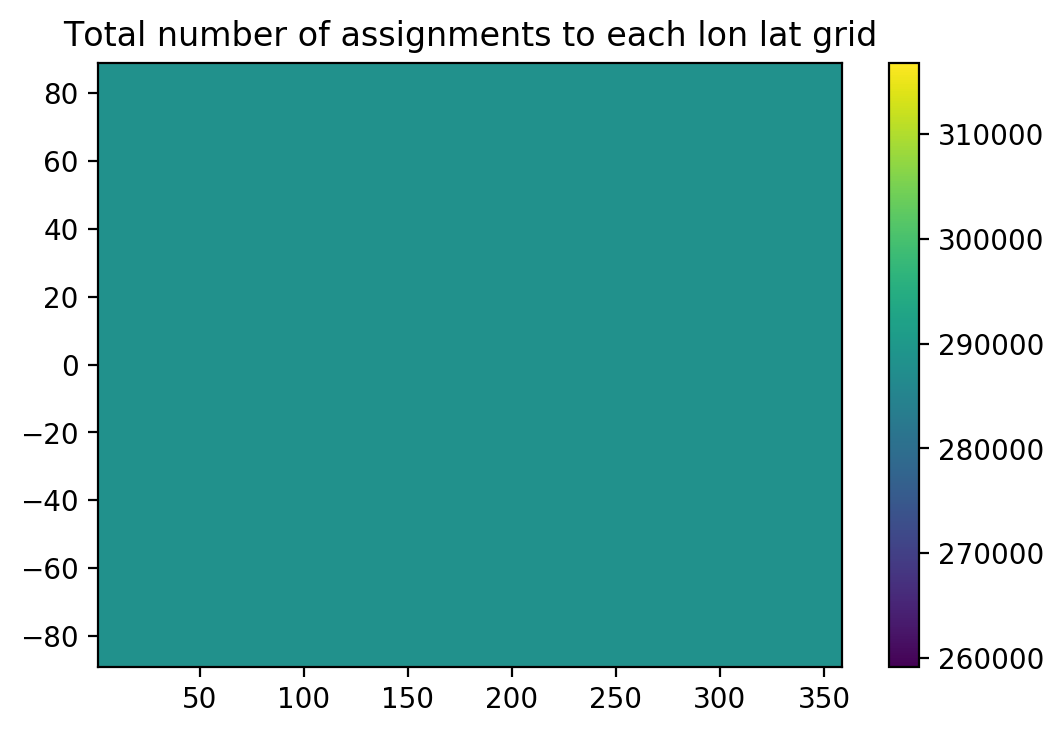

In [113]:
# sum across ecoregion assignments, each grid should have roughly the same number
# assigned. 
X_summed = np.sum(X, axis=0)

# The number of assignments in each grid cell can be used for calculate % coverage.
print np.unique(X_summed)

plt.figure(dpi=200)
plt.pcolor(lon+180., lat, X_summed)
plt.colorbar()
plt.title("Total number of assignments to each lon lat grid")
plt.show()

Ok that came out better than expected. The exact same number of 0.5 degree grid boxes were assigned to each massive 2.5 x 2 degree climate grid boxes. Dividing each number of assignments by (dim 0 counts) should give a percent area in that grid box that is covered by that land cover. This is the value we want to save moving forward with saving these data as a well documented nc file.  

In [139]:
LC_percent = np.zeros((X.shape))
for i in range(n_unique_lc):
    LC_percent[i,:,:] = X[i,:,:]/X_summed * 100.
    
print np.min(LC_percent)
print np.max(LC_percent)

LC_lat = lat
LC_lon = lon

0.0
100.0


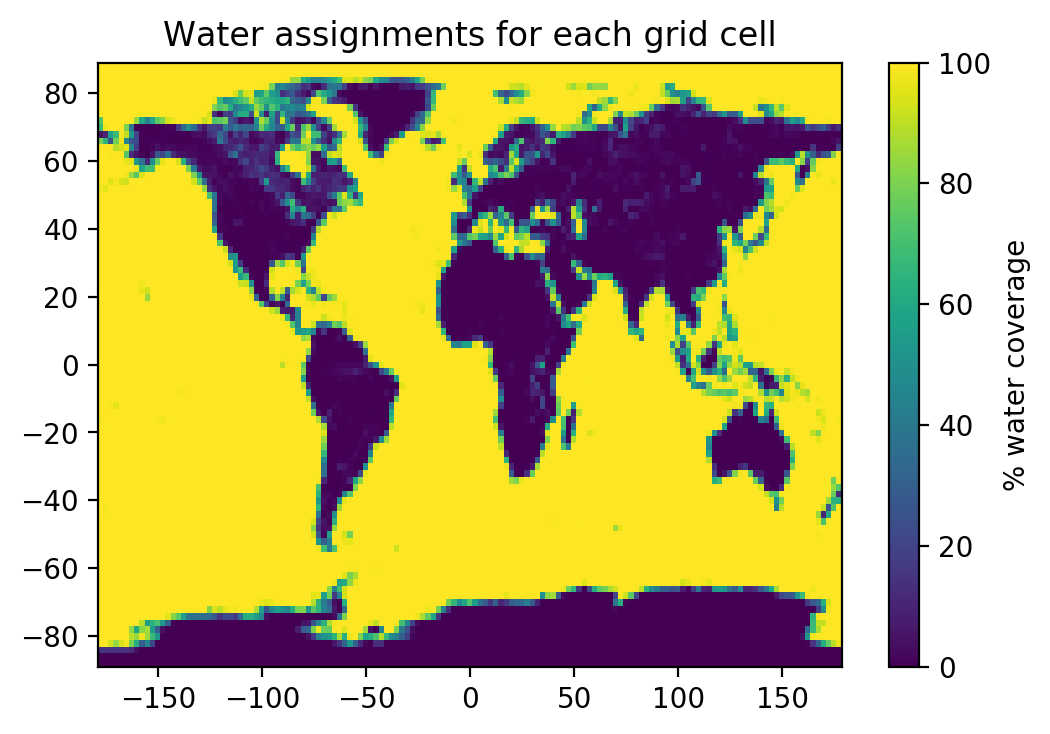

In [140]:
# Show the water
plt.figure(dpi=200)
plt.pcolor(LC_lon, LC_lat, LC_percent[0,:,:])
plt.colorbar(label="% water coverage")
plt.title("Water assignments for each grid cell")
plt.show()

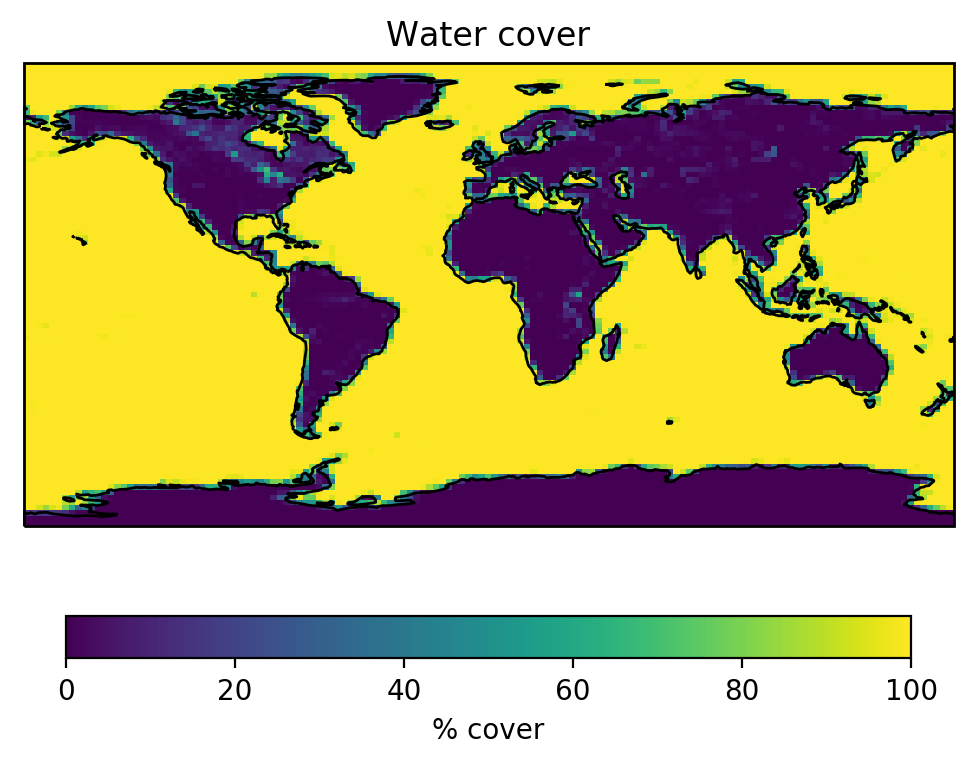

In [141]:
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point # For plotting around lon=0

import shapely.geometry as sgeom 
import cartopy.io.shapereader as shpreader


plt.figure(dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolor(LC_lon, LC_lat, LC_percent[0,:,:], transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Water cover")
plt.colorbar(orientation="horizontal", fraction=0.07, label="% cover")
plt.show()

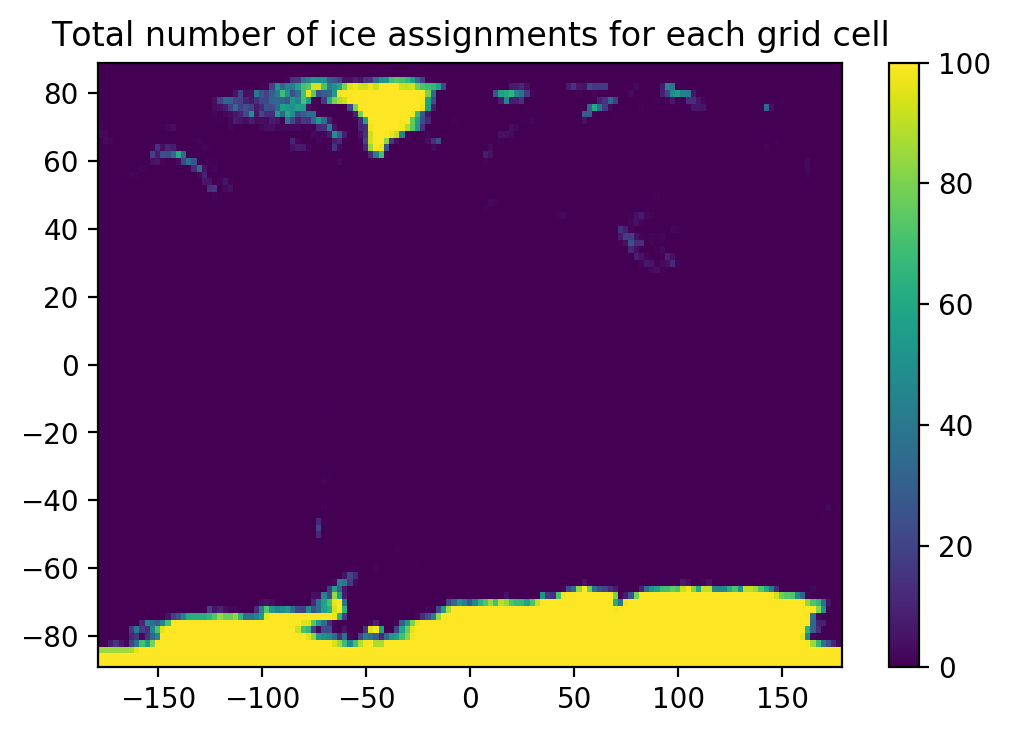

In [142]:
# Show snow and ice
plt.figure(dpi=200)
plt.pcolor(LC_lon, LC_lat, LC_percent[15,:,:])
plt.colorbar()
plt.title("Total number of ice assignments for each grid cell")
plt.show()

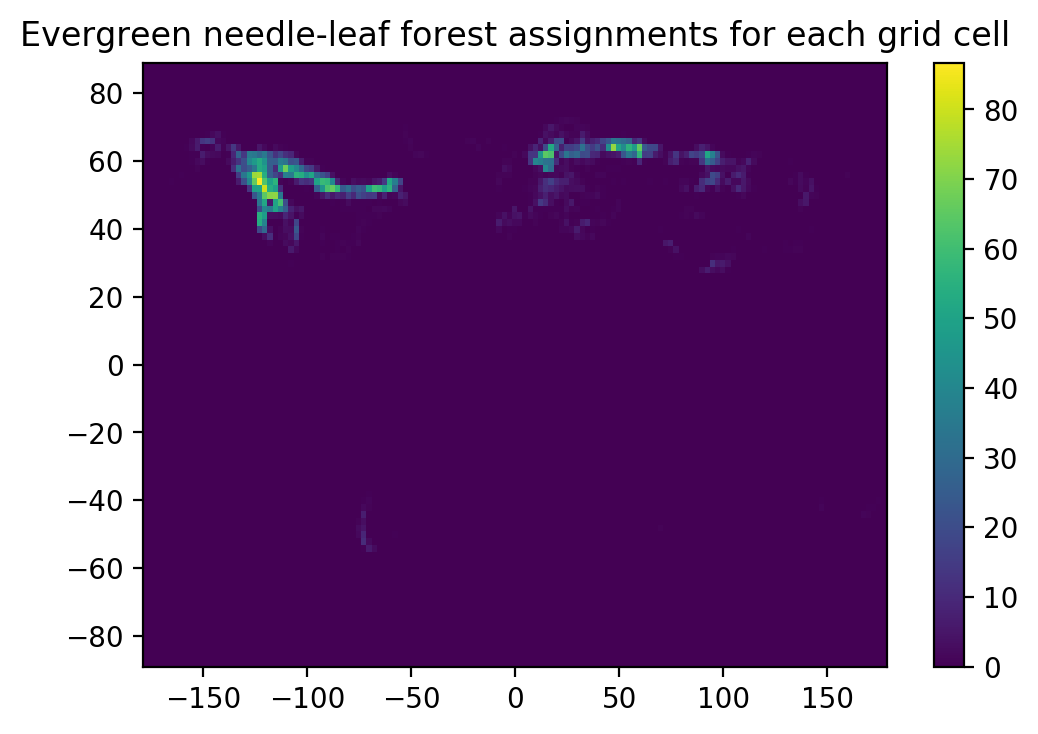

In [143]:
# Evergreen needle-lead forest
plt.figure(dpi=200)
plt.pcolor(LC_lon, LC_lat, LC_percent[1,:,:])
plt.colorbar()
plt.title("Evergreen needle-leaf forest assignments for each grid cell")
plt.show()

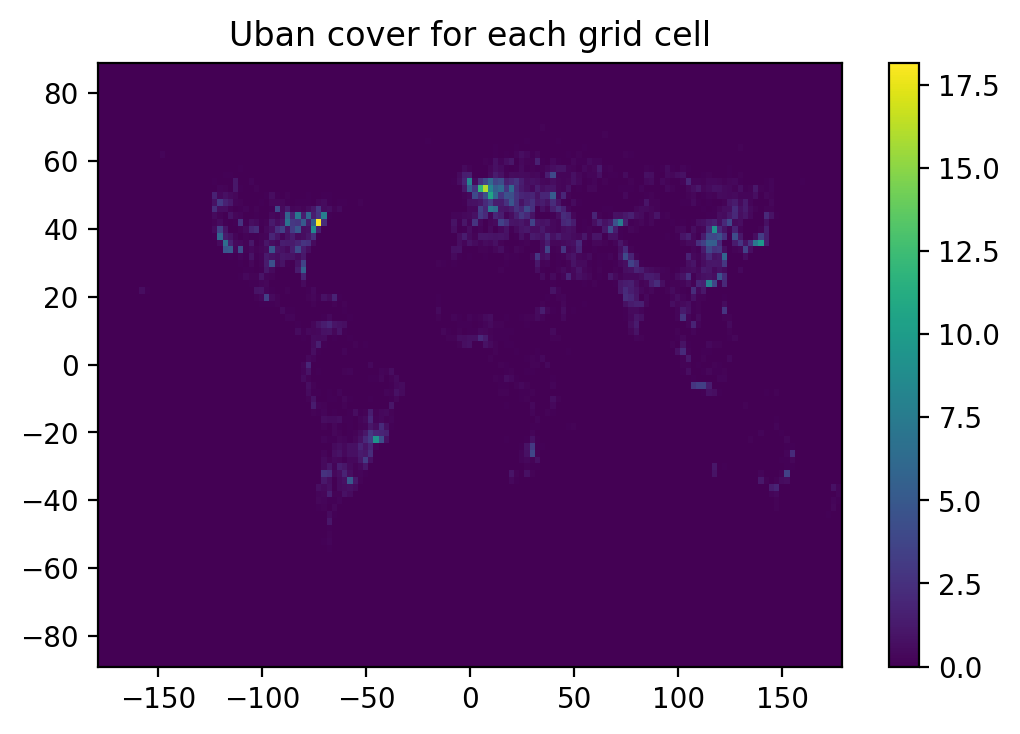

In [144]:
# urban and biult up
plt.figure(dpi=200)
plt.pcolor(LC_lon, LC_lat, LC_percent[13,:,:])
plt.colorbar()
plt.title("Uban cover for each grid cell")
plt.show()

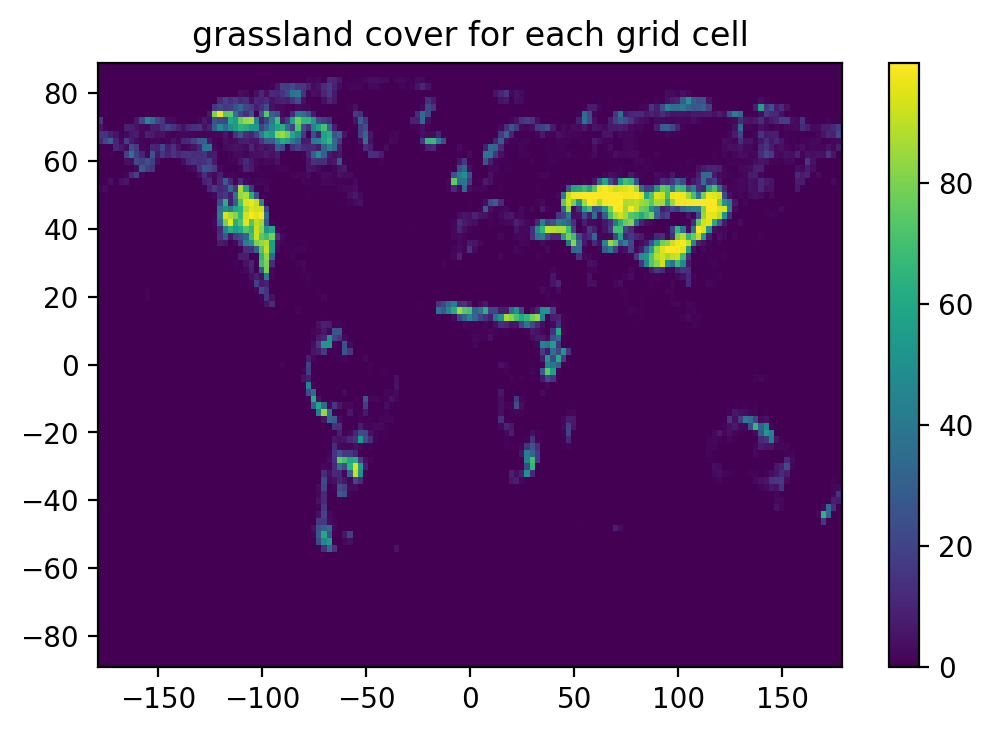

In [145]:
plt.figure(dpi=200)
plt.pcolor(LC_lon, LC_lat, LC_percent[10,:,:])
plt.colorbar()
plt.title("grassland cover for each grid cell")
plt.show()

In [167]:
# Get lon bnds from common nc data
nc = Dataset("../Data/CMIP5/r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID/grid_area.nc", "r")
cell_area = nc.variables["cell_area"][:]
#lon_bnds = nc.variables["lon_bnds"][:]
nc.close()

grid_area.shape

(90, 144)

### If the data looks sensible, save it as nc. 

In [169]:
outputFile = os.path.join("..","Data","LandCover", "LC_percent.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = '0.5 km MODIS-based Global Land Cover Climatology regridded to common grid used by CMIP5 models. Climatology is based on 2001-2010 data.'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(LC_lat) )
ncFile.createDimension('longitude', len(LC_lon) )
ncFile.createDimension('LC', n_unique_lc)

# Create data variables
VAR_ = ncFile.createVariable("LC_percent", 'f4',('LC','latitude','longitude'))
VAR_.units = "Classification"

cell_area_ = ncFile.createVariable("cell_area", 'f4',('latitude','longitude'))
cell_area_.units = "m2"

# Create lc variable
LC_ = ncFile.createVariable('LC_number', 'f4', ('LC',))
LC_.units = 'number is land cover type.'

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Write the actual data to these dimensions
VAR_[:]       = LC_percent
cell_area_[:] = cell_area
latitude_[:]  = LC_lat
longitude_[:] = LC_lon
LC_[:] = range(n_unique_lc)
ncFile.close()

Finally, convert this nc file to the exact same reference system as the CMIP5 data using cdo remapbil